In [1]:

using DataFrames, Gadfly, RDatasets


# Statistics

## 1.0 Introduction

Statistics transform raw data into data for new items. Statistics are the calculations for boxplots, violin plots, contours confidence ellipses, convex hulls etc. The new data produced by `Stastistics` are rendered by `Geometries`.

`Aesthetics `$\quad\rightarrow\quad$ `Statistics` $\quad\rightarrow\quad$  `Geometries`  
 ` x, y, z` $\quad\rightarrow\quad$ `Stat.contour` $\quad\rightarrow\quad$ `Geom.path`

In [3]:

Dsing = dataset("lattice","singer")
Dsing[:Voice] = [x[1:5] for x in Dsing[:VoicePart]]
head(Dsing)

,Height,VoicePart,Voice
1,64,Soprano 1,Sopra
2,62,Soprano 1,Sopra
3,66,Soprano 1,Sopra
4,65,Soprano 1,Sopra
5,60,Soprano 1,Sopra
6,61,Soprano 1,Sopra


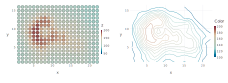

In [4]:

volcano = Matrix{Float64}(dataset("datasets", "volcano"))
volc = volcano[1:4:end, 1:4:end]
Dvolc = vcat([DataFrame(x=[1.0:22;],y=j, z=volc[:,j]) for j in 1:16 ]...)

coord = Coord.cartesian(xmin=1, xmax=22, ymin=1, ymax=16)
pa = plot(Dvolc, x=:x, y=:y, color=:z, Geom.point, coord, Theme(point_size=1.5mm)) 
pb = plot(z=volc, x=1.0:22, y=1.0:16, Stat.contour(levels=10), Geom.path, coord) 

draw(SVG(9inch,3.3inch),hstack(pa,pb))

The left plot shows the `aesthetics x,y,z`, in the right plot I apply `Stat.contour` and `Geom.path`.    
Yes it is possible to do strange things - in example 2 I mix `Stat.violin` with `Geom.polygon`:

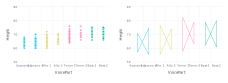

In [5]:

# Example 2

myTheme = Theme(key_position=:none)
pc = plot(Dsing, x=:VoicePart, y=:Height, color=:Voice, Geom.point, Scale.y_continuous(minvalue=50, maxvalue=90),myTheme)
pd = plot(Dsing, x=:VoicePart, y=:Height, color=:Voice, Stat.violin, Geom.polygon(preserve_order=true), myTheme)

draw(SVG(9inch,3.3inch),hstack(pc,pd))


**`Geoms`** make it easy for you, since `Geom.contour` = `Stat.contour` + `Geom.path`, then you only need to use `Geom.contour` etc.


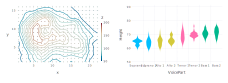

In [6]:

pe = plot(z=volc, x=1.0:22, y=1.0:16, coord, 
    layer(Dvolc, x=:x, y=:y, color=:z, Geom.point, style(point_size=0.2mm)),
    layer(Geom.contour(levels=10), order=2, style(line_width=0.5mm))
    ) 
pf = plot(Dsing, x=:VoicePart, y=:Height, color=:Voice, Geom.violin, myTheme)
draw(SVG(9inch,3.3inch), hstack(pe,pf))

## 2.0 Statistics w/o Geoms

There are some statistics that have no corresponding geometry
- Stat.qq
- Stat.binmean
- Stat.xjitter
- Stat.yjitter

## 3.0 Custom Statistics

Can I make my own Statistics?

In [10]:

module t

using Gadfly

struct PCAStatistic <: Gadfly.StatisticElement
    norm::Symbol
end
PCAStatistic(;norm=:covariance) = PCAStatistic(norm)

Gadfly.input_aesthetics(stat::PCAStatistic) = [:z]
Gadfly.output_aesthetics(stat::PCAStatistic) = [:x, :y]

Gadfly.default_scales(stat::PCAStatistic) = [Gadfly.Scale.z_func(), 
    Gadfly.Scale.x_continuous(), Gadfly.Scale.y_continuous()]


function Gadfly.Stat.apply_statistic(stat::PCAStatistic,
                         scales::Dict{Symbol, Gadfly.ScaleElement},
                         coord::Gadfly.CoordinateElement,
                         aes::Gadfly.Aesthetics)
    z = aes.z
    z .-= mean(z,1)
    (stat.norm==:correlation) && (z./= std(z,1))
    
    ev = eigvecs(Symmetric(cov(z)))
    U = z * ev[:, end:-1:(end-1)]
    U ./= std(U,1)
    aes.x = U[:,1] 
    aes.y = U[:,2]
    aes.z = nothing
end


pca = PCAStatistic

end


t

In [11]:

Dsleep = dataset("ggplot2", "msleep")
dict1 = Dict(i=>j for (j,i) in enumerate(unique(Dsleep[:Vore])))
Dsleep[:Vorei] = [dict1[x] for x in Dsleep[:Vore]]
Dsleep = dropmissing!(Dsleep[[:Vore, :Name,:Vorei,:BrainWt,:BodyWt,:SleepRem, :SleepTotal]])
 head(Dsleep)


,Vore,Name,Vorei,BrainWt,BodyWt,SleepRem,SleepTotal
1,omni,Owl monkey,2,0.0155,0.48,1.8,17.0
2,omni,Greater short-tailed shrew,2,0.00029,0.019,2.3,14.9
3,herbi,Cow,3,0.423,600.0,0.7,4.0
4,carni,Dog,1,0.07,14.0,2.9,10.1
5,herbi,Goat,3,0.115,33.5,0.6,5.3
6,herbi,Guinea pig,3,0.0055,0.728,0.8,9.4


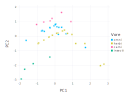

In [12]:

p = plot(Dsleep, z=Matrix{Float64}(Dsleep[:,3:end]), 
    t.pca(norm=:correlation), Geom.point,  color=:Vore, 
    Guide.xlabel("PC1"), Guide.ylabel("PC2")
    )
draw(SVG(5inch,4inch),p)

## 4.0 Future development

- make `Stat.contour` work with DataFrames